# New Section

Loading main data

In [ ]:
def evaluation(model,model_name,history,Xtrain,Xtest):



  print('=================================================================')
  print(f'------------------------------{model_name}--------------------------------')
  print('=================================================================')
  model.summary()
  Predictions = Target_Scaler.inverse_transform( model.predict(Xtest))
  Actual = Target_Scaler.inverse_transform(Ytest)
  Predictions = np.squeeze(Predictions , axis = 1)
  Actual = np.squeeze(Actual , axis = 1)
  print('=================================================================')
  print('--------')
  print('METRICS')
  print('--------')
  Metrics(model,model_name,Actual, Predictions)
  print('=================================================================')

  plt.rcParams["figure.figsize"] = (40,8)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.suptitle('Learning Curve')

  ax1.plot(history.history['mae'])
  ax1.plot(history.history['val_mae'])
  ax1.set_title('model MAE')
  ax1.set_ylabel('MAE')
  ax1.set_xlabel('epoch')
  ax1.legend(['Train', 'Validation'], loc='upper left')

  ax2.plot(history.history['loss'])
  ax2.plot(history.history['val_loss'])
  ax2.set_title('model MSE')
  ax2.set_ylabel('MSE')
  ax2.set_xlabel('epoch')
  ax2.legend(['Train', 'Validation'], loc='upper left')

  fig = go.Figure()
  fig.add_trace(go.Scatter(x = data.index[-test_length:] , y = Actual , mode = 'lines' , name='Actual'))
  fig.add_trace(go.Scatter(x = data.index[-test_length:] , y = Predictions , mode = 'lines' , name=f'Predicted_by_{model_name}'))
  fig.update_layout(
      title={
        'text': f'Evaluating {model_name} model perfomance in the Test set',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
  fig.show()
  Total_features = np.concatenate((Xtrain , Xtest) , axis = 0)
  Total_Targets = np.concatenate((Ytrain , Ytest) , axis = 0)
  total_Predictions = model.predict(Total_features)
  total_Predictions = Target_Scaler.inverse_transform(total_Predictions)
  total_Actual = Target_Scaler.inverse_transform(Total_Targets)
  total_Predictions = np.squeeze(total_Predictions , axis = 1)
  total_Actual = np.squeeze(total_Actual , axis = 1)
  fig = go.Figure()
  fig.add_trace(go.Scatter(x = data.index , y = total_Actual , mode = 'lines' , name='Actual'))
  fig.add_trace(go.Scatter(x = data.index , y = total_Predictions , mode = 'lines' , name=f'Predicted_by_{model_name}'))
  fig.update_layout(
    title={
        'text': f'Evaluating {model_name} model perfomance in the entire Dataset',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
  fig.show()


In [ ]:
def Metrics(model,model_name,y_test, prediction):
  #rmse = math.sqrt(mean_squared_error(y_test, prediction))
  mse=mean_squared_error(y_test, prediction)
  rmse = math.sqrt(mse)
  mae=median_absolute_error(y_test, prediction)
  mape=mean_absolute_percentage_error(y_test, prediction)
  r2=r2_score(y_test, prediction)
  result=pd.DataFrame({'model':model_name,'R2':r2,'rmse':rmse,'mse':mse,'mae':mae,'mape':mape},index=[0])
  # result=pd.DataFrame({'model':model_name,'rmse':rmse,'mse':mse,'mae':mae,'mape':mape},index=[0])
  display(result)
  return result

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import ModelCheckpoint , ReduceLROnPlateau
from tensorflow.python.keras.layers.legacy_rnn.rnn_cell_impl import BasicLSTMCell
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout , LSTM , Bidirectional , BatchNormalization, GRU, Embedding
from sklearn.metrics import mean_squared_error, median_absolute_error,mean_absolute_percentage_error,r2_score
import math

In [ ]:
data = pd.read_csv('/content/Scaled_btcData.csv', index_col='Date', encoding='utf8')

In [ ]:
data.head(3)

,High,Low,Close,Volume,RSI,SMA,EMA,MACD,MACD Signal,LB,UB,f_Score
Date,,,,,,,,,,,,
2020-07-02,0.002025,0.001120,0.000909,0.012064,0.307804,0.004314,0.001481,0.481928,0.490628,0.004847,0.017537,0.693433
2020-07-03,0.000721,0.001536,0.000245,0.002440,0.293549,0.003927,0.001184,0.481298,0.489779,0.004652,0.016953,0.458998
2020-07-04,0.000379,0.001439,0.001076,0.000112,0.317680,0.003472,0.000965,0.481245,0.489089,0.004538,0.016555,0.592645


In [ ]:
# Sort the data points based on indexes just for confirmation
data.sort_index(inplace = True)

In [ ]:
# Remove any duplicate index
data = data.loc[~data.index.duplicated(keep='first')]

In [ ]:
data.tail(3)

,High,Low,Close,Volume,RSI,SMA,EMA,MACD,MACD Signal,LB,UB,f_Score
Date,,,,,,,,,,,,
2021-08-01,0.599263,0.574165,0.567724,0.042619,0.601396,0.519127,0.544244,0.672005,0.600882,0.593622,0.398398,0.972210
2021-08-02,0.561158,0.559238,0.553523,0.039392,0.551235,0.522210,0.548384,0.667038,0.620818,0.601507,0.402682,0.806672
2021-08-03,0.549144,0.541123,0.534251,0.041147,0.486803,0.524159,0.550883,0.653019,0.633533,0.606180,0.408327,0.999971


In [ ]:
data.head(3)

,High,Low,Close,Volume,RSI,SMA,EMA,MACD,MACD Signal,LB,UB,f_Score
Date,,,,,,,,,,,,
2020-07-02,0.002025,0.001120,0.000909,0.012064,0.307804,0.004314,0.001481,0.481928,0.490628,0.004847,0.017537,0.693433
2020-07-03,0.000721,0.001536,0.000245,0.002440,0.293549,0.003927,0.001184,0.481298,0.489779,0.004652,0.016953,0.458998
2020-07-04,0.000379,0.001439,0.001076,0.000112,0.317680,0.003472,0.000965,0.481245,0.489089,0.004538,0.016555,0.592645


In [ ]:
# Check for missing values
data.isnull().sum()

High           0
Low            0
Close          0
Volume         0
RSI            0
SMA            0
EMA            0
MACD           0
MACD Signal    0
LB             0
UB             0
f_Score        0
dtype: int64

In [ ]:
# Get the statistics of the data
data.describe()

,High,Low,Close,Volume,RSI,SMA,EMA,MACD,MACD Signal,LB,UB,f_Score
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,0.392727,0.377761,0.387878,0.094979,0.503980,0.407437,0.405319,0.533332,0.544958,0.431391,0.358386,0.681928
std,0.318726,0.310372,0.315636,0.076081,0.213945,0.351223,0.345072,0.175909,0.192580,0.353137,0.310683,0.165941
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.049749,0.049262,0.049539,0.041090,0.344882,0.044781,0.042290,0.471971,0.477105,0.053715,0.051818,0.572037
50%,0.433522,0.414947,0.425576,0.082295,0.480413,0.447436,0.460443,0.534641,0.544754,0.469026,0.377898,0.679076
75%,0.647811,0.596606,0.618543,0.132482,0.677231,0.702156,0.699316,0.618545,0.642258,0.819990,0.526393,0.794076
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Understanding Trends with in the Data

In [ ]:
import plotly.graph_objects as go

In [ ]:
# Check the trend in Closing Values
fig = go.Figure()

fig.add_trace(go.Scatter(x = data.index , y = data['Close'] , mode = 'lines'))
fig.update_layout(height = 500 , width = 900,
                  xaxis_title='Date' , yaxis_title='Close')
fig.show()

In [ ]:
# Check the trend in Volume Traded
fig = go.Figure()

fig.add_trace(go.Scatter(x = data.index , y = data['Volume'] , mode = 'lines'))
fig.update_layout(height = 500 , width = 900,
                  xaxis_title='Date' , yaxis_title='Volume')
fig.show()

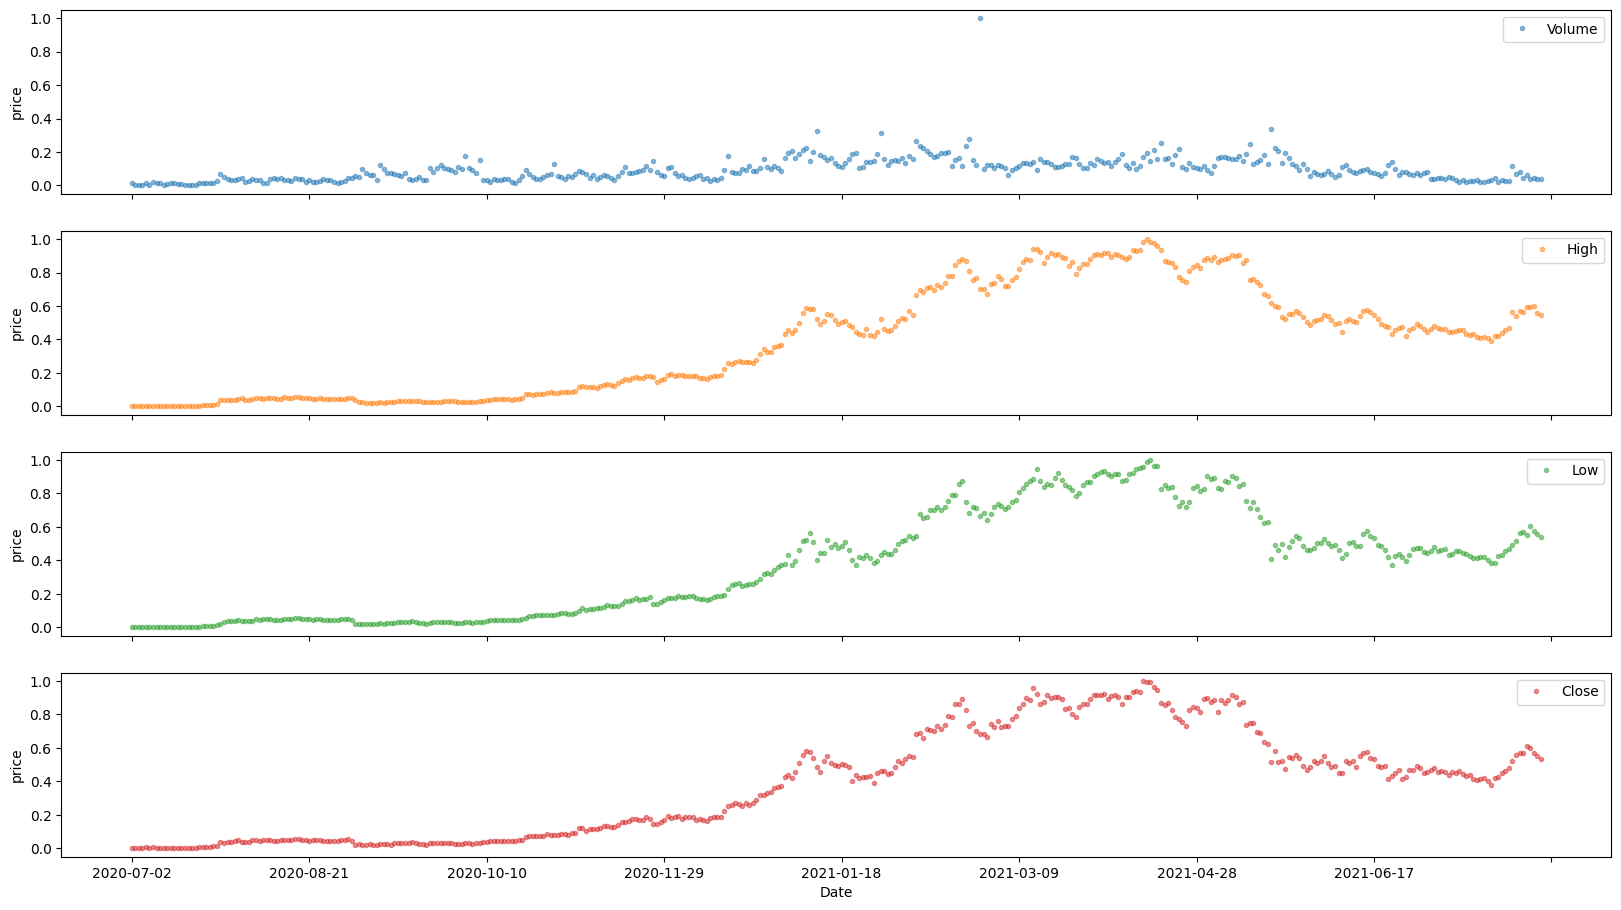

In [ ]:
cols_plot = ['Volume', 'High', 'Low','Close']
axes = data[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(20, 11), subplots=True)
for ax in axes:
    ax.set_ylabel('price')

<ipython-input-593-5c53a4506ee3>:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




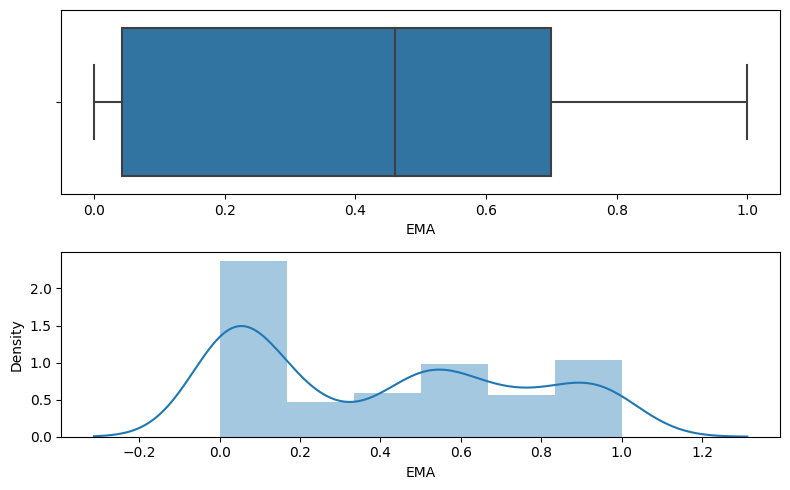

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (8, 5))
sns.boxplot(x= data["EMA"], ax = ax[0])
sns.distplot(data['EMA'], ax = ax[1])
plt.tight_layout()

In [ ]:
# Filter only required data
df = data[['Close' , 'Volume', 'RSI', 'f_Score']]
df.head(3)

,Close,Volume,RSI,f_Score
Date,,,,
2020-07-02,0.000909,0.012064,0.307804,0.693433
2020-07-03,0.000245,0.002440,0.293549,0.458998
2020-07-04,0.001076,0.000112,0.317680,0.592645


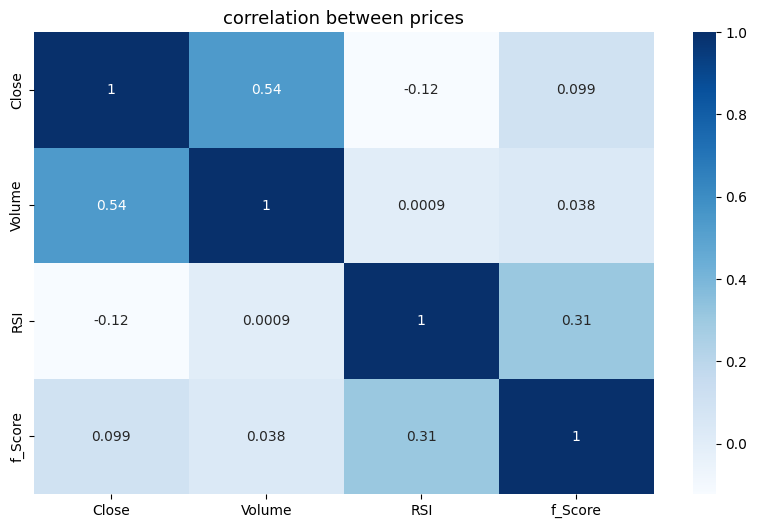

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(),cmap=plt.cm.Blues,annot=True)
plt.title('correlation between prices',
         fontsize=13)
plt.show()

Text(0, 0.5, 'Closing price')

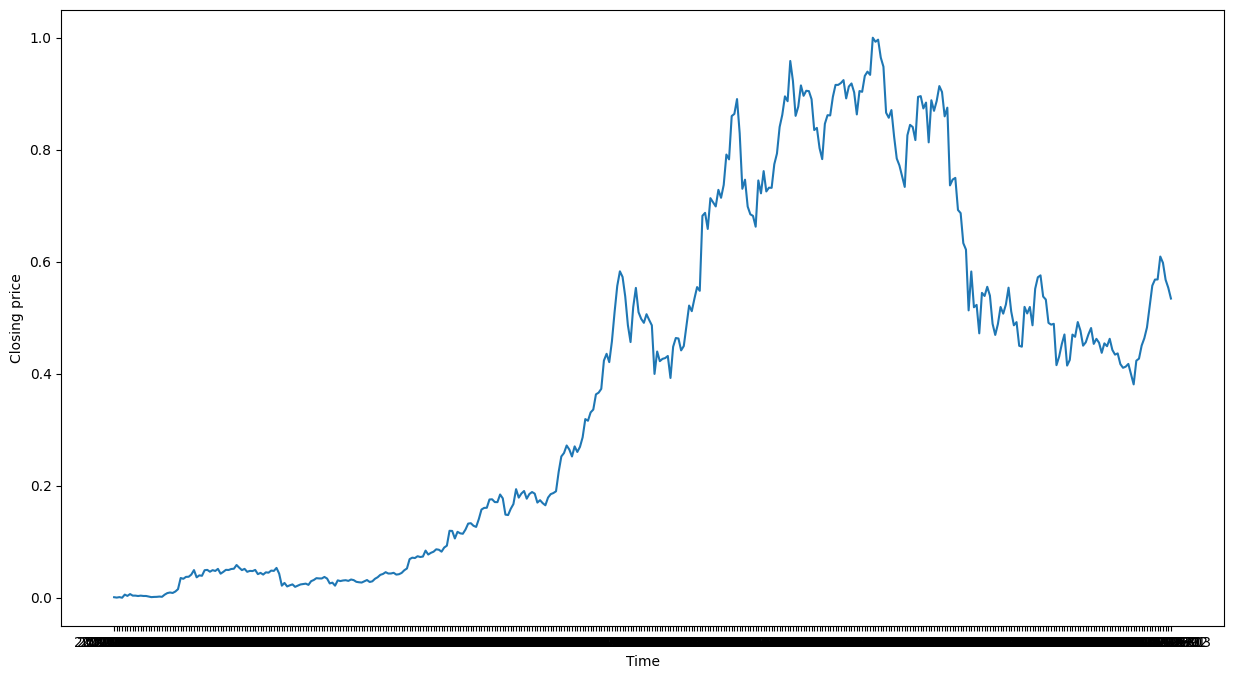

In [ ]:
plt.rcParams["figure.figsize"] = (15,8)
plt.plot(data['Close'], label="Close price")
plt.xlabel("Time")
plt.ylabel("Closing price")

Data Preparation

In [ ]:
# Confirm the Testing Set length
test_length = df[(df.index >= '2021-06-30')].shape[0]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import pickle
from tqdm.notebook import tnrange

Scrapping extra information

In [ ]:
def CreateFeatures_and_Targets(data, feature_length):
    X = []
    Y = []

    for i in tnrange(len(data) - feature_length):
        X.append(data.iloc[i : i + feature_length,:].values)
        Y.append(data["Close"].values[i+feature_length])

    X = np.array(X)
    Y = np.array(Y)

    return X , Y

In [ ]:
X , Y = CreateFeatures_and_Targets(df , 32)

  0%|          | 0/366 [00:00<?, ?it/s]

In [ ]:
# Check the shapes
X.shape , Y.shape

((366, 32, 4), (366,))

In [ ]:
Xtrain , Xtest , Ytrain , Ytest = X[:-test_length] , X[-test_length:] , Y[:-test_length] , Y[-test_length:]

In [ ]:
# Check Training Dataset Shape
Xtrain.shape , Ytrain.shape

((331, 32, 4), (331,))

In [ ]:
# Check Testing Dataset Shape
Xtest.shape , Ytest.shape

((35, 32, 4), (35,))

In [ ]:
# Create a Scaler to Scale Vectors with Multiple Dimensions
class MultiDimensionScaler():
    def __init__(self):
        self.scalers = []

    def fit_transform(self , X):
        total_dims = X.shape[2]
        for i in range(total_dims):
            Scaler = MinMaxScaler()
            X[:, :, i] = Scaler.fit_transform(X[:,:,i])
            self.scalers.append(Scaler)
        return X

    def transform(self , X):
        for i in range(X.shape[2]):
            X[:, :, i] = self.scalers[i].transform(X[:,:,i])
        return X

In [ ]:
Feature_Scaler = MultiDimensionScaler()
Xtrain = Feature_Scaler.fit_transform(Xtrain)
Xtest = Feature_Scaler.transform(Xtest)

In [ ]:
Target_Scaler = MinMaxScaler()
Ytrain = Target_Scaler.fit_transform(Ytrain.reshape(-1,1))
Ytest = Target_Scaler.transform(Ytest.reshape(-1,1))

In [ ]:
def save_object(obj , name : str):
    pickle_out = open(f"{name}.pck","wb")
    pickle.dump(obj, pickle_out)
    pickle_out.close()

def load_object(name : str):
    pickle_in = open(f"{name}.pck","rb")
    data = pickle.load(pickle_in)
    return data

In [ ]:
# Save your objects for future purposes
save_object(Feature_Scaler , "Feature_Scaler")
save_object(Target_Scaler , "Target_Scaler")

Model Building

In [ ]:
# X_train_series_sub = Xtrain.reshape((Xtrain.shape[0], 32, 3, 1))
# X_valid_series_sub = Xtest.reshape((Xtest.shape[0], 32, 3, 1))
# print('Train set shape', X_train_series_sub.shape)
# print('Validation set shape', X_valid_series_sub.shape)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint , ReduceLROnPlateau

save_best = ModelCheckpoint("GRU_best_weights.h5", monitor='val_loss', save_best_only=True, save_weights_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25,patience=5, min_lr=0.00001,verbose = 1)

In [ ]:
# from tensorflow.python import metrics
# #optimizer = tf.keras.optimizers.SGD(learning_rate = 0.002)
# #model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
# optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0028)

In [ ]:
from tensorflow.python.keras.layers.legacy_rnn.rnn_cell_impl import BasicLSTMCell
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout , LSTM , Bidirectional , BatchNormalization, GRU, Embedding

GRU_model = Sequential()
GRU_model.add(GRU(64, activation='tanh',recurrent_activation='sigmoid',recurrent_dropout=0.0, unroll = False,use_bias=True,
              reset_after = True))
GRU_model.add(Dropout(0.3))
GRU_model.add(Dense(64 , activation='elu'))
GRU_model.add(Dropout(0.3))
GRU_model.add(Dense(32 , activation='elu'))
GRU_model.add(Dense(1 , activation='linear'))



In [ ]:
from tensorflow.python import metrics
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
GRU_model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

In [ ]:
GRU_history = GRU_model.fit(Xtrain, Ytrain,
            epochs=100,
            batch_size = 64,
            verbose=1,
            shuffle=False ,
            validation_data=(Xtest , Ytest),
            callbacks=[reduce_lr , save_best])

Epoch 1/100
6/6 [==============================] - 5s 99ms/step - loss: 0.1943 - mae: 0.3655 - val_loss: 0.0096 - val_mae: 0.0892 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 14ms/step - loss: 0.1884 - mae: 0.3624 - val_loss: 0.0088 - val_mae: 0.0880 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 14ms/step - loss: 0.1222 - mae: 0.2986 - val_loss: 0.0081 - val_mae: 0.0876 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 0s 12ms/step - loss: 0.0734 - mae: 0.2246 - val_loss: 0.0153 - val_mae: 0.1202 - lr: 0.0010
Epoch 5/100
6/6 [==============================] - 0s 13ms/step - loss: 0.0404 - mae: 0.1583 - val_loss: 0.0023 - val_mae: 0.0389 - lr: 0.0010
Epoch 6/100
6/6 [==============================] - 0s 14ms/step - loss: 0.0260 - mae: 0.1273 - val_loss: 0.0014 - val_mae: 0.0306 - lr: 0.0010
Epoch 7/100
6/6 [==============================] - 0s 15ms/step - loss: 0.0208 - mae: 0.1153 - val_loss: 0.0016 - val_mae: 0.0335 - lr: 0.0010

------------------------------GRU--------------------------------
Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_61 (GRU)                (None, 64)                13440     
                                                                 
 dropout_90 (Dropout)        (None, 64)                0         
                                                                 
 dense_159 (Dense)           (None, 64)                4160      
                                                                 
 dropout_91 (Dropout)        (None, 64)                0         
                                                                 
 dense_160 (Dense)           (None, 32)                2080      
                                                                 
 dense_161 (Dense)           (None, 1)                 33        
                                                     

,model,R2,rmse,mse,mae,mape
0,GRU,0.743322,0.029854,0.000891,0.018554,0.050813


12/12 [==============================] - 0s 4ms/step


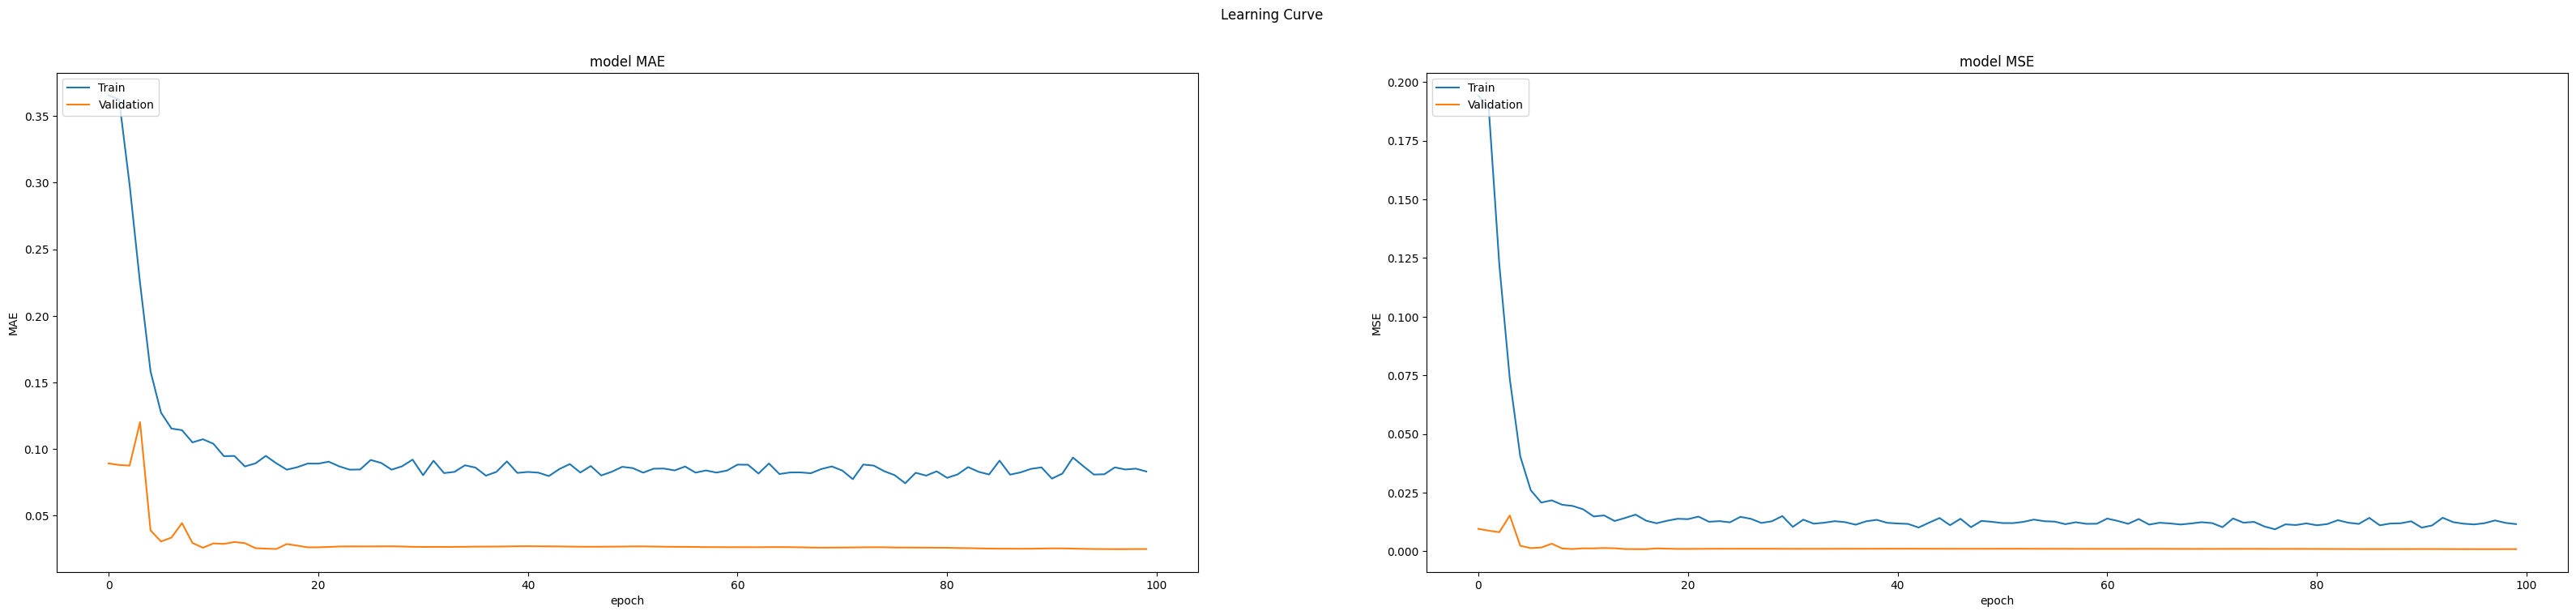

In [ ]:
evaluation(GRU_model,'GRU',GRU_history,Xtrain,Xtest)

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(64, activation='tanh',recurrent_activation='sigmoid',recurrent_dropout=0.0, unroll = False,use_bias=True,
                   ))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(64 , activation='elu'))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(32 , activation='elu'))
model_lstm.add(Dense(1 , activation='linear'))
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
model_lstm.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

In [ ]:
LSTM_history = model_lstm.fit(Xtrain, Ytrain,
            epochs=100,
            batch_size = 64,
            verbose=1,
            shuffle=False ,
            validation_data=(Xtest , Ytest),
            callbacks=[reduce_lr , save_best])

Epoch 1/100
6/6 [==============================] - 3s 97ms/step - loss: 0.1927 - mae: 0.3423 - val_loss: 0.0020 - val_mae: 0.0357 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 12ms/step - loss: 0.0926 - mae: 0.2597 - val_loss: 0.0157 - val_mae: 0.1203 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 12ms/step - loss: 0.0758 - mae: 0.2328 - val_loss: 0.0022 - val_mae: 0.0349 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0383 - mae: 0.1525 - val_loss: 0.0054 - val_mae: 0.0541 - lr: 0.0010
Epoch 5/100
6/6 [==============================] - 0s 12ms/step - loss: 0.0270 - mae: 0.1257 - val_loss: 0.0036 - val_mae: 0.0548 - lr: 0.0010
Epoch 6/100
1/6 [====>.........................] - ETA: 0s - loss: 0.0098 - mae: 0.0835
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
6/6 [==============================] - 0s 12ms/step - loss: 0.0240 - mae: 0.1169 - val_loss: 0.0031 - val_mae: 0.0511 - l

------------------------------LSTM--------------------------------
Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 64)                17664     
                                                                 
 dropout_92 (Dropout)        (None, 64)                0         
                                                                 
 dense_162 (Dense)           (None, 64)                4160      
                                                                 
 dropout_93 (Dropout)        (None, 64)                0         
                                                                 
 dense_163 (Dense)           (None, 32)                2080      
                                                                 
 dense_164 (Dense)           (None, 1)                 33        
                                                    

,model,R2,rmse,mse,mae,mape
0,LSTM,0.477195,0.042606,0.001815,0.020129,0.060795


12/12 [==============================] - 0s 3ms/step


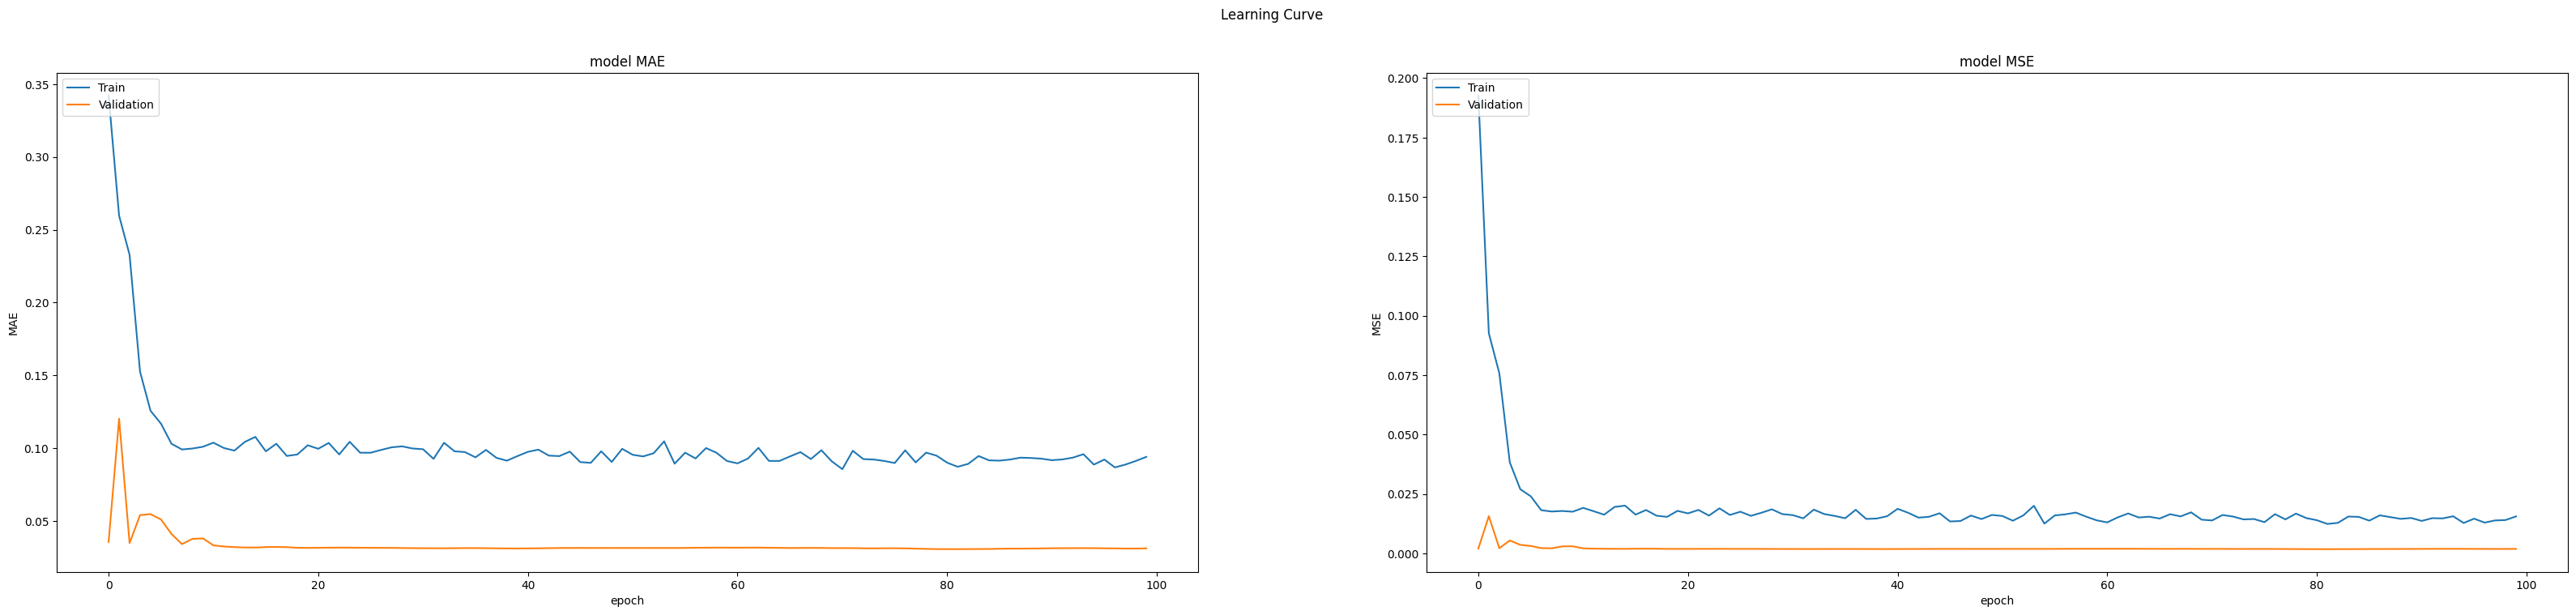

In [ ]:
evaluation(model_lstm,'LSTM',LSTM_history,Xtrain,Xtest)

In [ ]:
from tensorflow.keras.layers import MaxPooling1D, Flatten,GlobalAveragePooling1D,Conv1D
from tensorflow.keras.optimizers import Adam
lr = 0.001
save_best = ModelCheckpoint("cnn_best_weights.h5", monitor='val_loss', save_best_only=True, save_weights_only=True)
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dropout(0.3))
model_cnn.add(Dense(50 , activation='elu'))
model_cnn.add(Dense(1 , activation='linear'))

# model_cnn.add(Dense(50, activation='relu'))
# model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=Adam(lr), metrics=['mae'])

In [ ]:
cnn_history = model_cnn.fit(Xtrain, Ytrain,
            epochs=100,
            batch_size = 64,
            verbose=1,
            shuffle=False ,
            validation_data=(Xtest , Ytest),
            callbacks=[reduce_lr , save_best])

Epoch 1/200
6/6 [==============================] - 2s 43ms/step - loss: 0.2713 - mae: 0.4079 - val_loss: 0.0576 - val_mae: 0.2305 - lr: 0.0010
Epoch 2/200
6/6 [==============================] - 0s 14ms/step - loss: 0.2794 - mae: 0.4133 - val_loss: 0.0607 - val_mae: 0.2251 - lr: 0.0010
Epoch 3/200
6/6 [==============================] - 0s 17ms/step - loss: 0.4591 - mae: 0.5950 - val_loss: 0.0065 - val_mae: 0.0712 - lr: 0.0010
Epoch 4/200
6/6 [==============================] - 0s 10ms/step - loss: 0.0759 - mae: 0.2387 - val_loss: 0.0145 - val_mae: 0.1095 - lr: 0.0010
Epoch 5/200
6/6 [==============================] - 0s 10ms/step - loss: 0.0974 - mae: 0.2816 - val_loss: 0.0448 - val_mae: 0.2038 - lr: 0.0010
Epoch 6/200
6/6 [==============================] - 0s 12ms/step - loss: 0.0478 - mae: 0.1678 - val_loss: 0.0044 - val_mae: 0.0508 - lr: 0.0010
Epoch 7/200
6/6 [==============================] - 0s 14ms/step - loss: 0.0277 - mae: 0.1388 - val_loss: 0.0067 - val_mae: 0.0732 - lr: 0.0010

------------------------------cnn--------------------------------
Model: "sequential_78"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 31, 128)           1152      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 15, 128)          0         
 1D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 1920)              0         
                                                                 
 dropout_100 (Dropout)       (None, 1920)              0         
                                                                 
 dense_177 (Dense)           (None, 50)                96050     
                                                                 
 dense_178 (Dense)           (None, 1)               

,model,R2,rmse,mse,mae,mape
0,cnn,0.330761,0.04916,0.002417,0.035401,0.095734


12/12 [==============================] - 0s 2ms/step


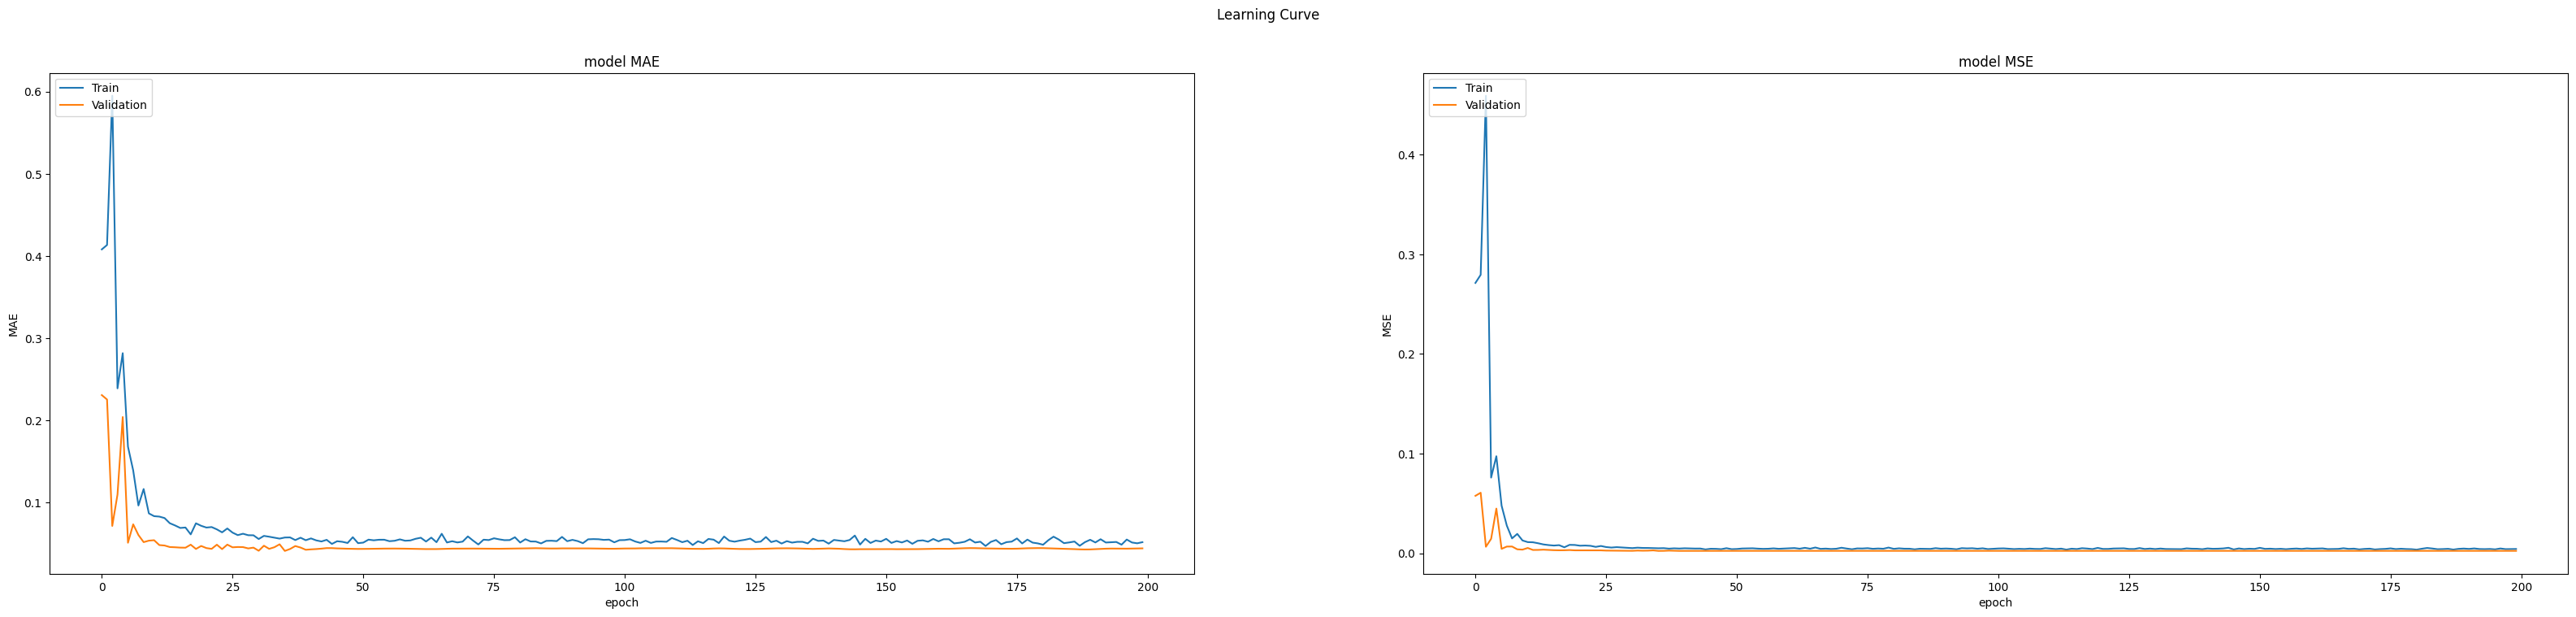

In [ ]:
evaluation(model_cnn,'cnn',cnn_history,Xtrain,Xtest)

In [ ]:
X_train_series_sub = Xtrain.reshape((Xtrain.shape[0], 32, 4, 1))
X_valid_series_sub = Xtest.reshape((Xtest.shape[0], 32, 4, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (331, 32, 4, 1)
Validation set shape (35, 32, 4, 1)


In [ ]:
epochsss=200
batchsizeee=64
LearnR=0.001
Layersize=128
Droutt=0.33

In [ ]:
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed,Conv1D,RepeatVector,Reshape,Conv2D

model_cnn_gru = Sequential()
model_cnn_gru.add(Conv2D(Layersize, (4, 4), input_shape=(None,Xtrain.shape[2], 1)))
model_cnn_gru.add(Dropout(Droutt))
model_cnn_gru.add(Reshape(target_shape=(29, Layersize)))
model_cnn_gru.add(GRU(Layersize, return_sequences=False))
model_cnn_gru.add(Dense(Layersize, activation='relu'))
model_cnn_gru.add(Dense(1))
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = LearnR)
model_cnn_gru.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

In [ ]:
Target_Scaler = MinMaxScaler()
Ytrain = Target_Scaler.fit_transform(Ytrain.reshape(-1,1))
Ytest = Target_Scaler.transform(Ytest.reshape(-1,1))

In [ ]:
model_cnn_gru_history = model_cnn_gru.fit(X_train_series_sub, Ytrain,
            epochs=epochsss,
            batch_size = batchsizeee,
            verbose=1,
            shuffle=False ,
            validation_data=(X_valid_series_sub , Ytest))

Epoch 1/200
6/6 [==============================] - 2s 94ms/step - loss: 0.1321 - mae: 0.2879 - val_loss: 0.0134 - val_mae: 0.1060
Epoch 2/200
6/6 [==============================] - 0s 12ms/step - loss: 0.1208 - mae: 0.3015 - val_loss: 0.0041 - val_mae: 0.0568
Epoch 3/200
6/6 [==============================] - 0s 11ms/step - loss: 0.0505 - mae: 0.1964 - val_loss: 0.0011 - val_mae: 0.0265
Epoch 4/200
6/6 [==============================] - 0s 14ms/step - loss: 0.0161 - mae: 0.1123 - val_loss: 0.0023 - val_mae: 0.0425
Epoch 5/200
6/6 [==============================] - 0s 12ms/step - loss: 0.0062 - mae: 0.0614 - val_loss: 0.0024 - val_mae: 0.0337
Epoch 6/200
6/6 [==============================] - 0s 12ms/step - loss: 0.0079 - mae: 0.0719 - val_loss: 0.0018 - val_mae: 0.0387
Epoch 7/200
6/6 [==============================] - 0s 12ms/step - loss: 0.0046 - mae: 0.0494 - val_loss: 0.0016 - val_mae: 0.0285
Epoch 8/200
6/6 [==============================] - 0s 12ms/step - loss: 0.0049 - mae: 0.05

------------------------------CNN_GRU--------------------------------
Model: "sequential_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, None, 1, 128)      2176      
                                                                 
 dropout_103 (Dropout)       (None, None, 1, 128)      0         
                                                                 
 reshape_52 (Reshape)        (None, 29, 128)           0         
                                                                 
 gru_68 (GRU)                (None, 128)               99072     
                                                                 
 dense_183 (Dense)           (None, 128)               16512     
                                                                 
 dense_184 (Dense)           (None, 1)                 129       
                                                 

,model,R2,rmse,mse,mae,mape
0,CNN_GRU,0.867417,0.021881,0.000479,0.018326,0.038364


12/12 [==============================] - 0s 2ms/step


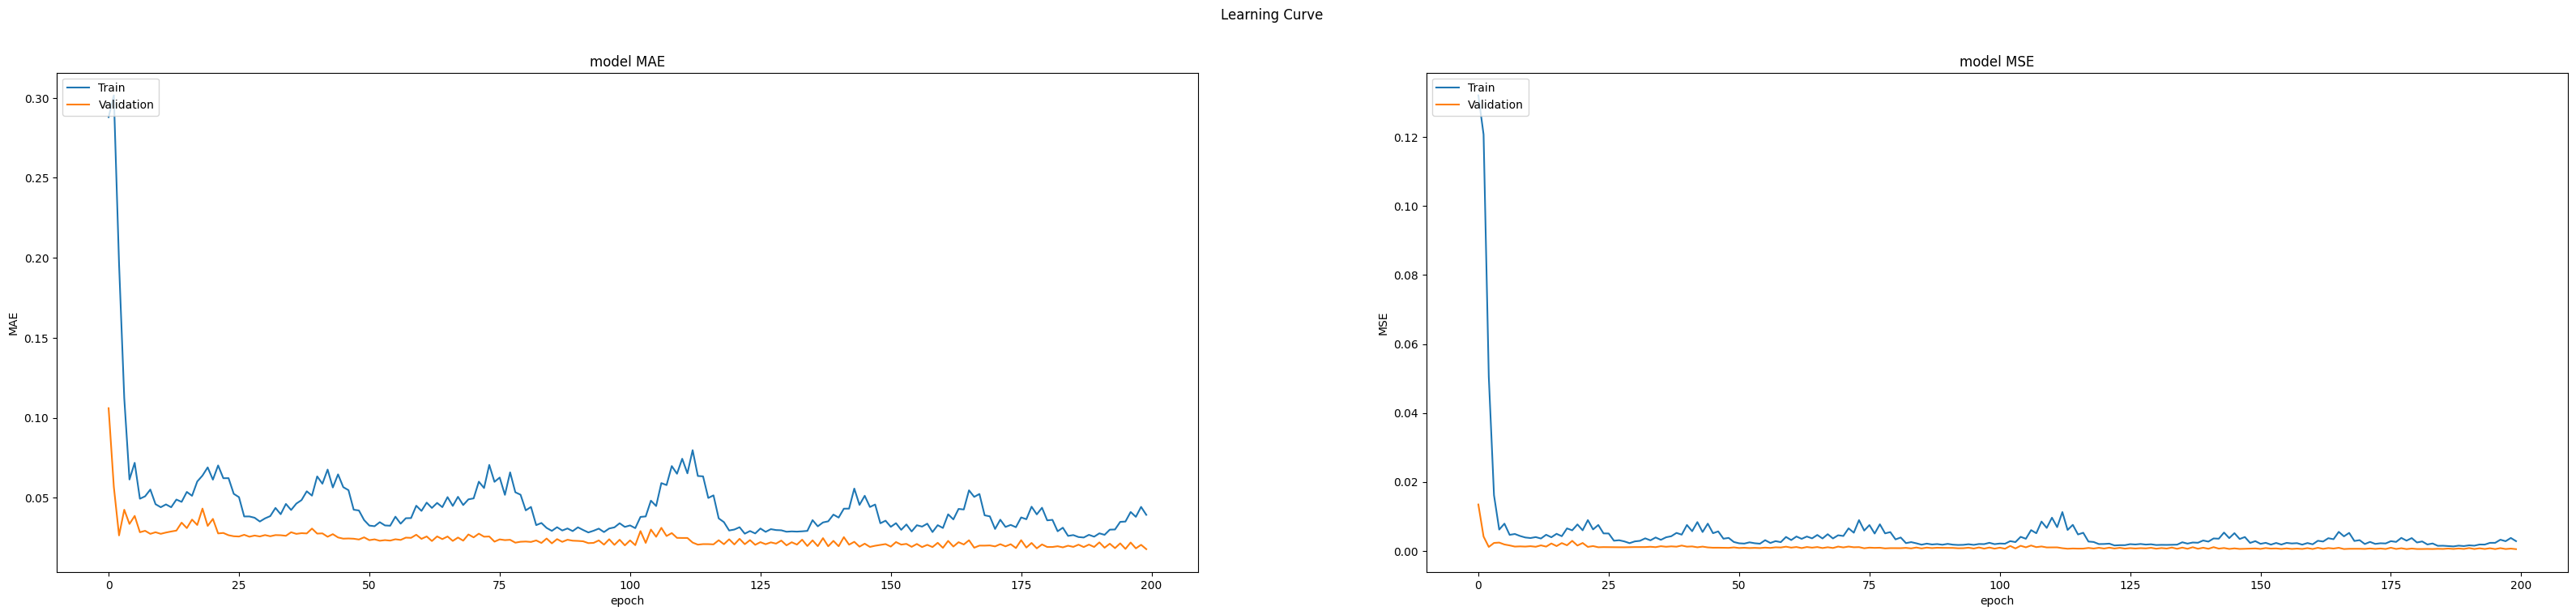

In [ ]:
evaluation(model_cnn_gru,'CNN_GRU',model_cnn_gru_history,Xtrain,Xtest)

Visualize prediction on Test Set

In [ ]:
metric=pd.DataFrame()
Actual = Target_Scaler.inverse_transform(Ytest)
Actual = np.squeeze(Actual , axis = 1)

Predictions = Target_Scaler.inverse_transform( GRU_model.predict(Xtest))
gru_Predictions = np.squeeze(Predictions , axis = 1)
gru=Metrics(GRU_model,'GRU',Actual, gru_Predictions)
Predictions = Target_Scaler.inverse_transform( model_lstm.predict(Xtest))
lstm_Predictions = np.squeeze(Predictions , axis = 1)
LSTM=Metrics(model_lstm,'LSTM',Actual, lstm_Predictions)
Predictions = Target_Scaler.inverse_transform( model_cnn.predict(Xtest))
cnn_Predictions = np.squeeze(Predictions , axis = 1)
CNN=Metrics(model_cnn,'CNN',Actual, cnn_Predictions)
X_train_series_sub = Xtrain.reshape((Xtrain.shape[0], 32, 4, 1))
X_valid_series_sub = Xtest.reshape((Xtest.shape[0], 32, 4, 1))
#Predictions = Target_Scaler.inverse_transform( model_cnn_lstm.predict(X_valid_series_sub))
#cnn_lstm_Predictions = np.squeeze(Predictions , axis = 1)
#CNN_LSTM=Metrics(model_cnn_lstm,'CNN_LSTM',Actual, cnn_lstm_Predictions)
Predictions = Target_Scaler.inverse_transform( model_cnn_gru.predict(Xtest))
cnn_gru_Predictions = np.squeeze(Predictions , axis = 1)
CNN_GRU=Metrics(model_cnn_gru,'CNN_GRU',Actual, cnn_gru_Predictions)

metric=pd.concat([CNN,gru,LSTM,CNN_GRU],axis=0)

2/2 [==============================] - 0s 6ms/step


,model,R2,rmse,mse,mae,mape
0,GRU,0.743323,0.030445,0.000927,0.018922,0.052987


2/2 [==============================] - 0s 6ms/step


,model,R2,rmse,mse,mae,mape
0,LSTM,0.477196,0.04345,0.001888,0.020528,0.063286


2/2 [==============================] - 0s 4ms/step


,model,R2,rmse,mse,mae,mape
0,CNN,0.330761,0.04916,0.002417,0.035401,0.095734


2/2 [==============================] - 0s 5ms/step


,model,R2,rmse,mse,mae,mape
0,CNN_GRU,0.867417,0.021881,0.000479,0.018326,0.038364


In [ ]:
metric.to_csv('/content/sample_data/ModelCompare.csv')

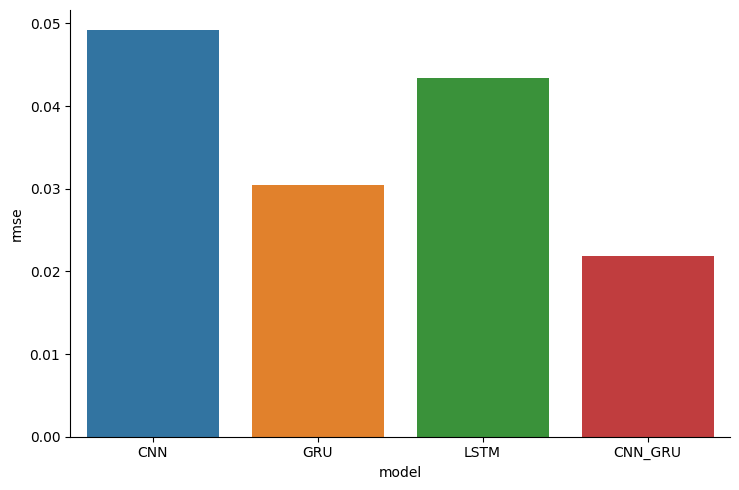

In [ ]:
p = sns.catplot(kind='bar', data=metric, x='model', y='rmse', height=5, aspect=1.5)

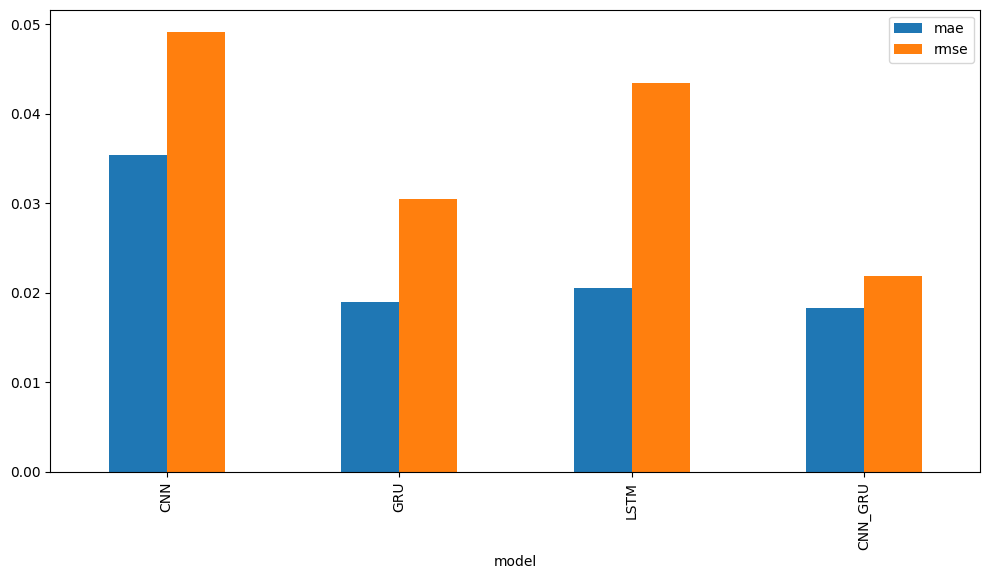

In [ ]:
ax = metric.plot.bar(x='model', y=['mae','rmse'],figsize=(12, 6) )

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = data.index[-test_length:] , y = Actual , mode = 'lines' , name='Actual'))
fig.add_trace(go.Scatter(x = data.index[-test_length:] , y = gru_Predictions , mode = 'lines' , name='GRU'))
fig.add_trace(go.Scatter(x = data.index[-test_length:] , y = lstm_Predictions , mode = 'lines' , name='LSTM'))
fig.add_trace(go.Scatter(x = data.index[-test_length:] , y = cnn_Predictions , mode = 'lines' , name='CNN'))
fig.add_trace(go.Scatter(x = data.index[-test_length:] , y = cnn_gru_Predictions , mode = 'lines' , name='CNN_GRU'))



fig.update_layout(
    title={
      'text': f'Evaluating different models perfomance in the Test set',
      'y':0.9,
      'x':0.5,
      'xanchor': 'center',
      'yanchor': 'top'})
fig.show()